# PointNet Model 


### Custom Dataset

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class RoadPointCloudDataset(Dataset):
    def __init__(self, data_dir, class_names, num_points=1024, transform=None):
        self.data_dir = data_dir
        self.class_names = class_names
        self.num_points = num_points
        self.transform = transform
        self.data = []

        for label_idx, class_name in enumerate(class_names):
            class_folder = os.path.join(data_dir, class_name)
            for fname in os.listdir(class_folder):
                if fname.endswith(".npy"):
                    self.data.append((os.path.join(class_folder, fname), label_idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx]
        point_cloud = np.load(file_path)

        
        point_cloud = point_cloud[:, :22]

        if point_cloud.shape[0] >= self.num_points:
            indices = np.random.choice(point_cloud.shape[0], self.num_points, replace=False)
        else:
            pad = np.zeros((self.num_points - point_cloud.shape[0], point_cloud.shape[1]))
            point_cloud = np.vstack((point_cloud, pad))
            indices = np.arange(self.num_points)

        sampled = point_cloud[indices]

        if self.transform:
            sampled = self.transform(sampled)

        return torch.tensor(sampled, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [2]:
# Your class labels (folder names)
labels = ["2lanes", "3lanes", "crossing", "split4lanes", "split6lanes", "transition"]

# Create dataset object
dataset = RoadPointCloudDataset(data_dir="dataset", class_names=labels, num_points=1024)

# Load a sample
sample_points, sample_label = dataset[0]
print(sample_points.shape)  # should be (1024, 7)
print(sample_label)         # class label as integer

torch.Size([1024, 22])
tensor(0)


### PointNet Classifier Code

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PointNetClassifier(nn.Module):
    def __init__(self, input_dim=7, num_classes=6):
        super(PointNetClassifier, self).__init__()

        self.conv1 = nn.Conv1d(input_dim, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, 1)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.bn3 = nn.BatchNorm1d(1024)

        self.fc1 = nn.Linear(1024, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x shape: [batch_size, num_points, input_dim]
        x = x.transpose(1, 2)  # → [batch_size, input_dim, num_points]

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = torch.max(x, 2)[0]  # global max pooling

        x = F.relu(self.bn4(self.fc1(x)))
        x = self.drop1(x)

        x = F.relu(self.bn5(self.fc2(x)))
        x = self.drop2(x)

        x = self.fc3(x)
        return x


### Training & Evaluation 

In [5]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# 1. Prepare Data
labels = ["2lanes", "3lanes", "crossing", "split4lanes", "split6lanes", "transition"]

# Create full dataset
dataset = RoadPointCloudDataset(data_dir="dataset", class_names=labels, num_points=1024)

# Split into train/test
from sklearn.model_selection import train_test_split
indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

from torch.utils.data import Subset
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# 2. Initialize Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointNetClassifier(input_dim=22, num_classes=6)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for points, labels_batch in train_loader:
        points, labels_batch = points.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(points)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss:.4f}")

# 4. Evaluation
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for points, labels_batch in test_loader:
        points, labels_batch = points.to(device), labels_batch.to(device)
        outputs = model(points)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels_batch.cpu().numpy())

accuracy = accuracy_score(all_targets, all_preds)
print(f"\n✅ Final Test Accuracy: {accuracy:.4f}")


Epoch 1/20 | Loss: 103.1512
Epoch 2/20 | Loss: 87.8217
Epoch 3/20 | Loss: 86.6286
Epoch 4/20 | Loss: 81.4027
Epoch 5/20 | Loss: 81.8159
Epoch 6/20 | Loss: 73.8707
Epoch 7/20 | Loss: 73.0428
Epoch 8/20 | Loss: 69.7834
Epoch 9/20 | Loss: 67.2731
Epoch 10/20 | Loss: 67.2994
Epoch 11/20 | Loss: 64.9580
Epoch 12/20 | Loss: 64.6251
Epoch 13/20 | Loss: 62.9773
Epoch 14/20 | Loss: 60.8847
Epoch 15/20 | Loss: 62.9397
Epoch 16/20 | Loss: 62.9030
Epoch 17/20 | Loss: 60.4651
Epoch 18/20 | Loss: 57.0048
Epoch 19/20 | Loss: 55.8142
Epoch 20/20 | Loss: 57.6206

✅ Final Test Accuracy: 0.4947


### Metrics Report

In [33]:
from sklearn.metrics import classification_report

target_names = ["2lanes", "3lanes", "crossing", "split4lanes", "split6lanes", "transition"]
print(classification_report(all_targets, all_preds, target_names=target_names))


              precision    recall  f1-score   support

      2lanes       0.87      0.80      0.83        91
      3lanes       0.56      0.11      0.19        44
    crossing       0.00      0.00      0.00        28
 split4lanes       0.33      0.55      0.41        33
 split6lanes       0.35      0.92      0.50        39
  transition       0.48      0.30      0.37        50

    accuracy                           0.52       285
   macro avg       0.43      0.45      0.39       285
weighted avg       0.53      0.52      0.48       285



### Confusion Matrix

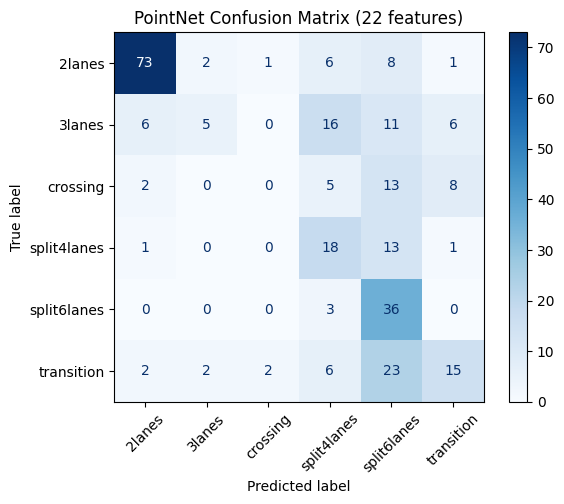

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("PointNet Confusion Matrix (22 features)")
plt.show()


### Visualize a Prediction in 3D

In [37]:
import plotly.graph_objects as go

# Sample 3D point cloud
sample_points, true_label = test_dataset[0]
sample_points_input = sample_points.unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    pred = torch.argmax(model(sample_points_input)).item()

# Plot
fig = go.Figure(data=[go.Scatter3d(
    x=sample_points[:, 0],  # local x
    y=sample_points[:, 1],  # local y
    z=sample_points[:, 2],  # local z
    mode='markers',
    marker=dict(
        size=2,
        color=sample_points[:, 9],  # color by intensity
        colorscale='Viridis',
        opacity=0.8
    )
)])
fig.update_layout(
    title=f"True: {target_names[true_label]} | Predicted: {target_names[pred]}",
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()


### global coordinate

In [38]:
global_x = sample_points[:, 6]  # feature 6
global_y = sample_points[:, 7]  # feature 7


### Visualize Location in 3D

In [39]:
import plotly.graph_objects as go

# Select a sample from the test set
sample_points, true_label = test_dataset[0]
sample_points = sample_points.cpu().numpy()

# Extract global coordinates and height
x_global = sample_points[:, 6]  # global X
y_global = sample_points[:, 7]  # global Y
z_height = sample_points[:, 2]  # local Z
intensity = sample_points[:, 9]  # intensity (for color)

# Plot in 3D space
fig = go.Figure(data=[go.Scatter3d(
    x=x_global,
    y=y_global,
    z=z_height,
    mode='markers',
    marker=dict(
        size=2,
        color=intensity,
        colorscale='Viridis',
        opacity=0.7
    )
)])

fig.update_layout(
    title="3D Location View of Point Cloud (Real Coordinates)",
    scene=dict(
        xaxis_title="Global X",
        yaxis_title="Global Y",
        zaxis_title="Elevation (Z)"
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


### Simple RandLA-Inspired Network(NOT WORKING)

In [25]:
class RandLASimpleClassifier(nn.Module):
    def __init__(self, input_dim=7, num_classes=6):
        super(RandLASimpleClassifier, self).__init__()

        self.conv1 = nn.Conv1d(input_dim, 128, 1)
        self.bn1 = nn.BatchNorm1d(128)

        self.conv2 = nn.Conv1d(128, 256, 1)
        self.bn2 = nn.BatchNorm1d(256)

        self.conv3 = nn.Conv1d(256, 512, 1)
        self.bn3 = nn.BatchNorm1d(512)

        self.global_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = self.global_pool(x).squeeze(-1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [17]:
model = RandLASimpleClassifier(input_dim=7, num_classes=6).to(device)


### training

In [26]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for points, labels_batch in train_loader:
        points, labels_batch = points.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(points)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss:.4f}")


Epoch 1/20 | Loss: 124.7360
Epoch 2/20 | Loss: 125.0267
Epoch 3/20 | Loss: 125.1700
Epoch 4/20 | Loss: 124.8346
Epoch 5/20 | Loss: 124.9698
Epoch 6/20 | Loss: 124.8416
Epoch 7/20 | Loss: 124.9031
Epoch 8/20 | Loss: 124.7680
Epoch 9/20 | Loss: 124.8753
Epoch 10/20 | Loss: 124.3814
Epoch 11/20 | Loss: 124.5931
Epoch 12/20 | Loss: 125.0676
Epoch 13/20 | Loss: 124.6235
Epoch 14/20 | Loss: 124.1646
Epoch 15/20 | Loss: 124.2345
Epoch 16/20 | Loss: 123.9041
Epoch 17/20 | Loss: 124.2438
Epoch 18/20 | Loss: 124.6652
Epoch 19/20 | Loss: 123.8914
Epoch 20/20 | Loss: 124.3088


In [ ]:
print("Model output shape:", outputs.shape)
print("Labels shape:", labels_batch.shape)


Model output shape: torch.Size([13, 6])
Labels shape: torch.Size([13])


### Evaluate It

In [21]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for points, labels_batch in test_loader:
        points, labels_batch = points.to(device), labels_batch.to(device)
        outputs = model(points)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels_batch.cpu().numpy())

# Print Accuracy + Confusion Matrix
print("✅ Accuracy:", accuracy_score(all_targets, all_preds))


✅ Accuracy: 0.3192982456140351
